In [10]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
import os

# Configurar matplotlib para VSCode
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

# Paths absolutos
BASE_DIR = "/Users/diego/Documents/tesis_standalone/tesis_unet_2"
MODEL_PATHS = {
    'last12': f"{BASE_DIR}/logs/last12/test_results.h5",
    'unet3': f"{BASE_DIR}/logs/unet3/test_results.h5",
    'unet4': f"{BASE_DIR}/logs/unet4/test_results.h5"
}

In [11]:
def load_results(h5_path):
    """Carga resultados de un modelo"""
    with h5py.File(h5_path, 'r') as f:
        data = {
            'inputs': f['inputs'][:],
            'targets': f['targets'][:],
            'predictions': f['predictions'][:],
            'metrics': {
                'mse': f.attrs['metric_mse'],
                'csi': f.attrs['metric_csi'],
                'far': f.attrs['metric_far'],
                'hss': f.attrs['metric_hss']
            },
            'model_type': f.attrs['model_type']
        }
    
    print(f"✅ {data['model_type']} - Secuencias: {data['inputs'].shape[0]}")
    print(f"   MSE: {data['metrics']['mse']:.4f}, CSI: {data['metrics']['csi']:.4f}")
    return data

# Cargar todos los modelos
results = {}
for name, path in MODEL_PATHS.items():
    if os.path.exists(path):
        results[name] = load_results(path)

✅ last12 - Secuencias: 29
   MSE: 0.0670, CSI: 0.0136
✅ unet3 - Secuencias: 29
   MSE: 0.0090, CSI: 0.1929
✅ unet4 - Secuencias: 29
   MSE: 0.0089, CSI: 0.1946


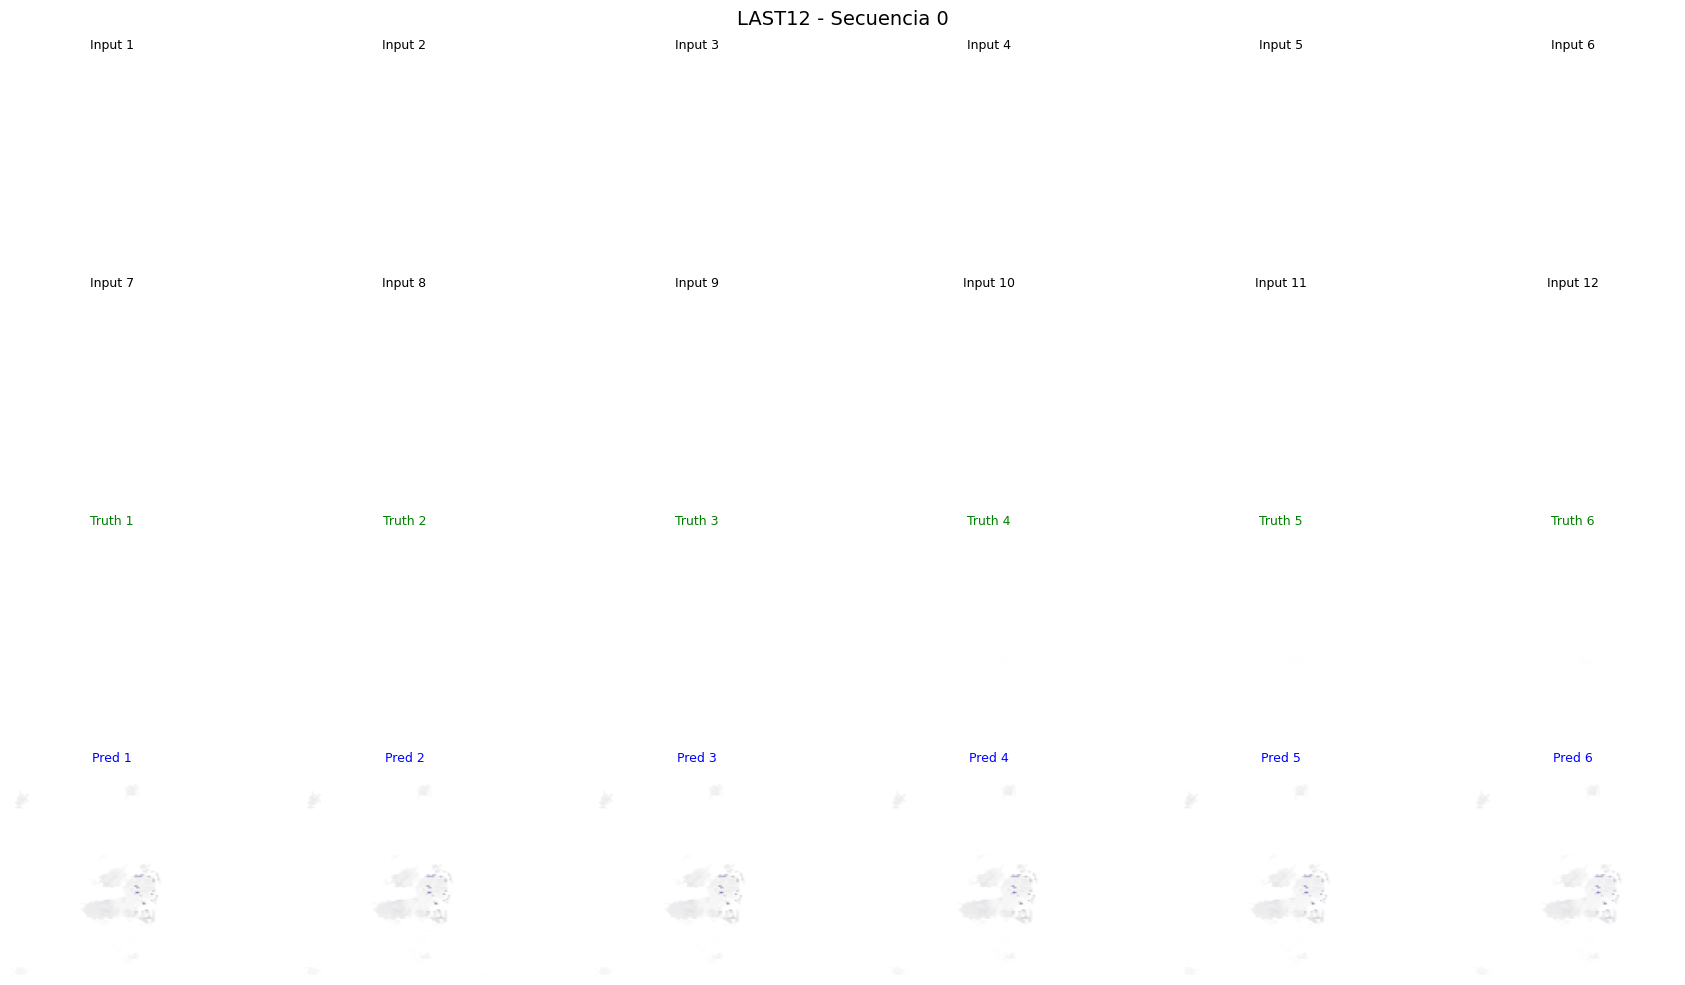

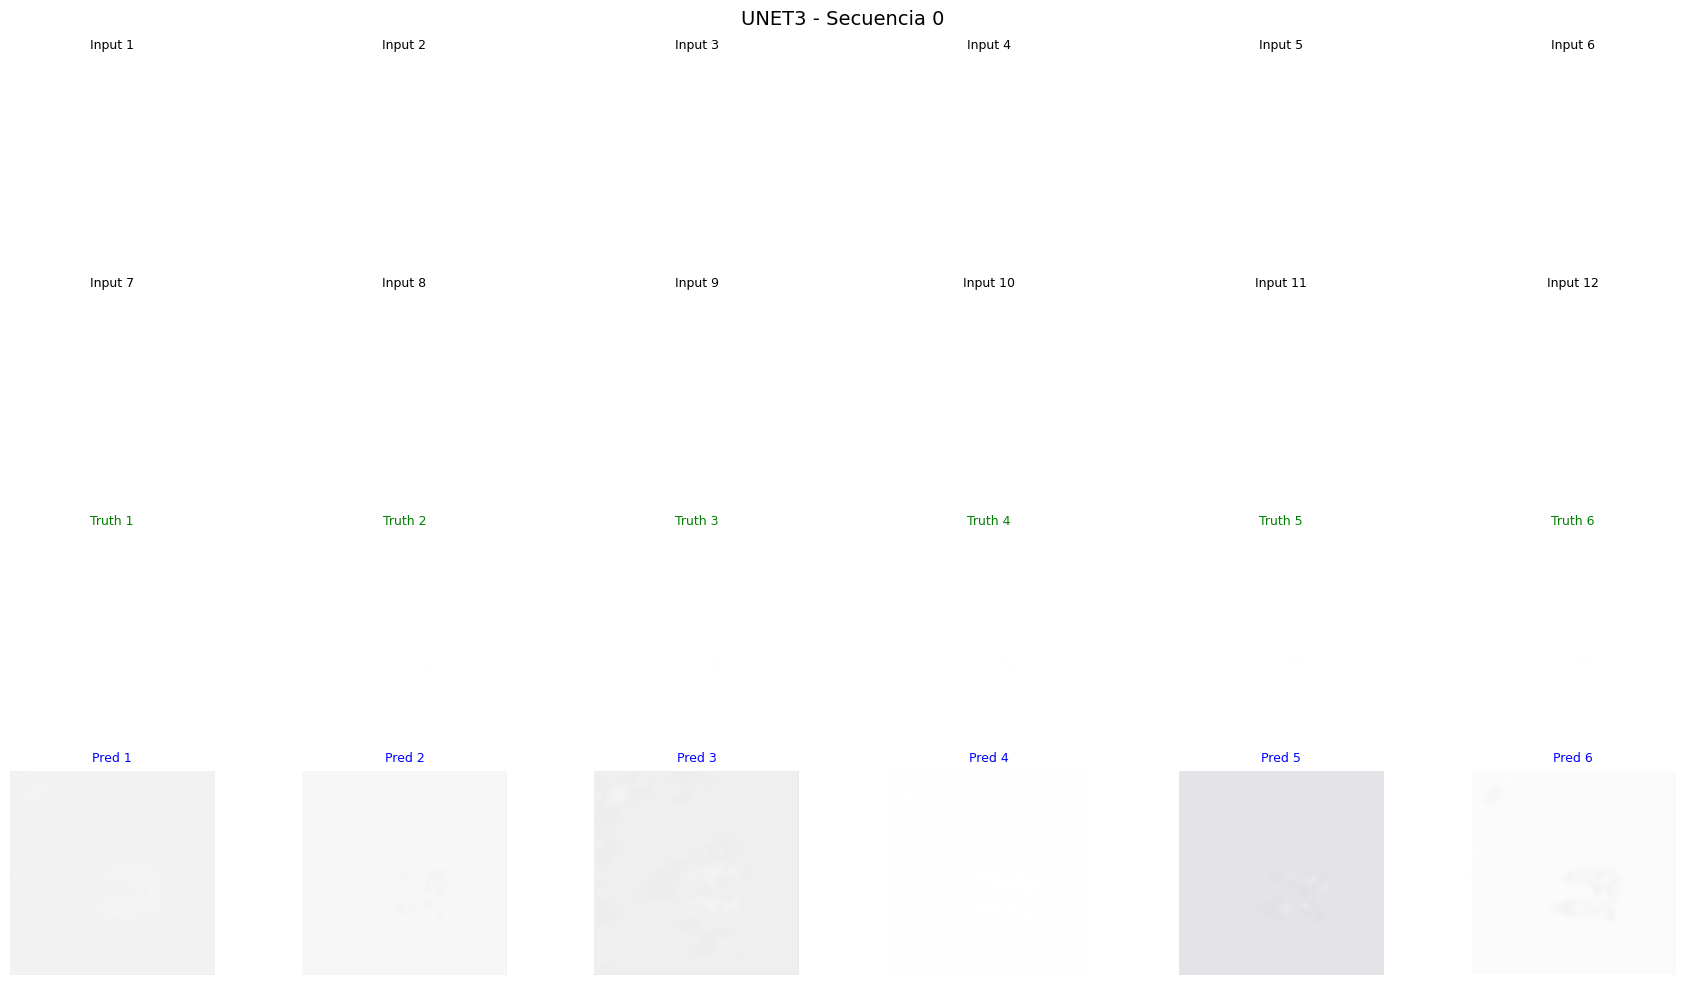

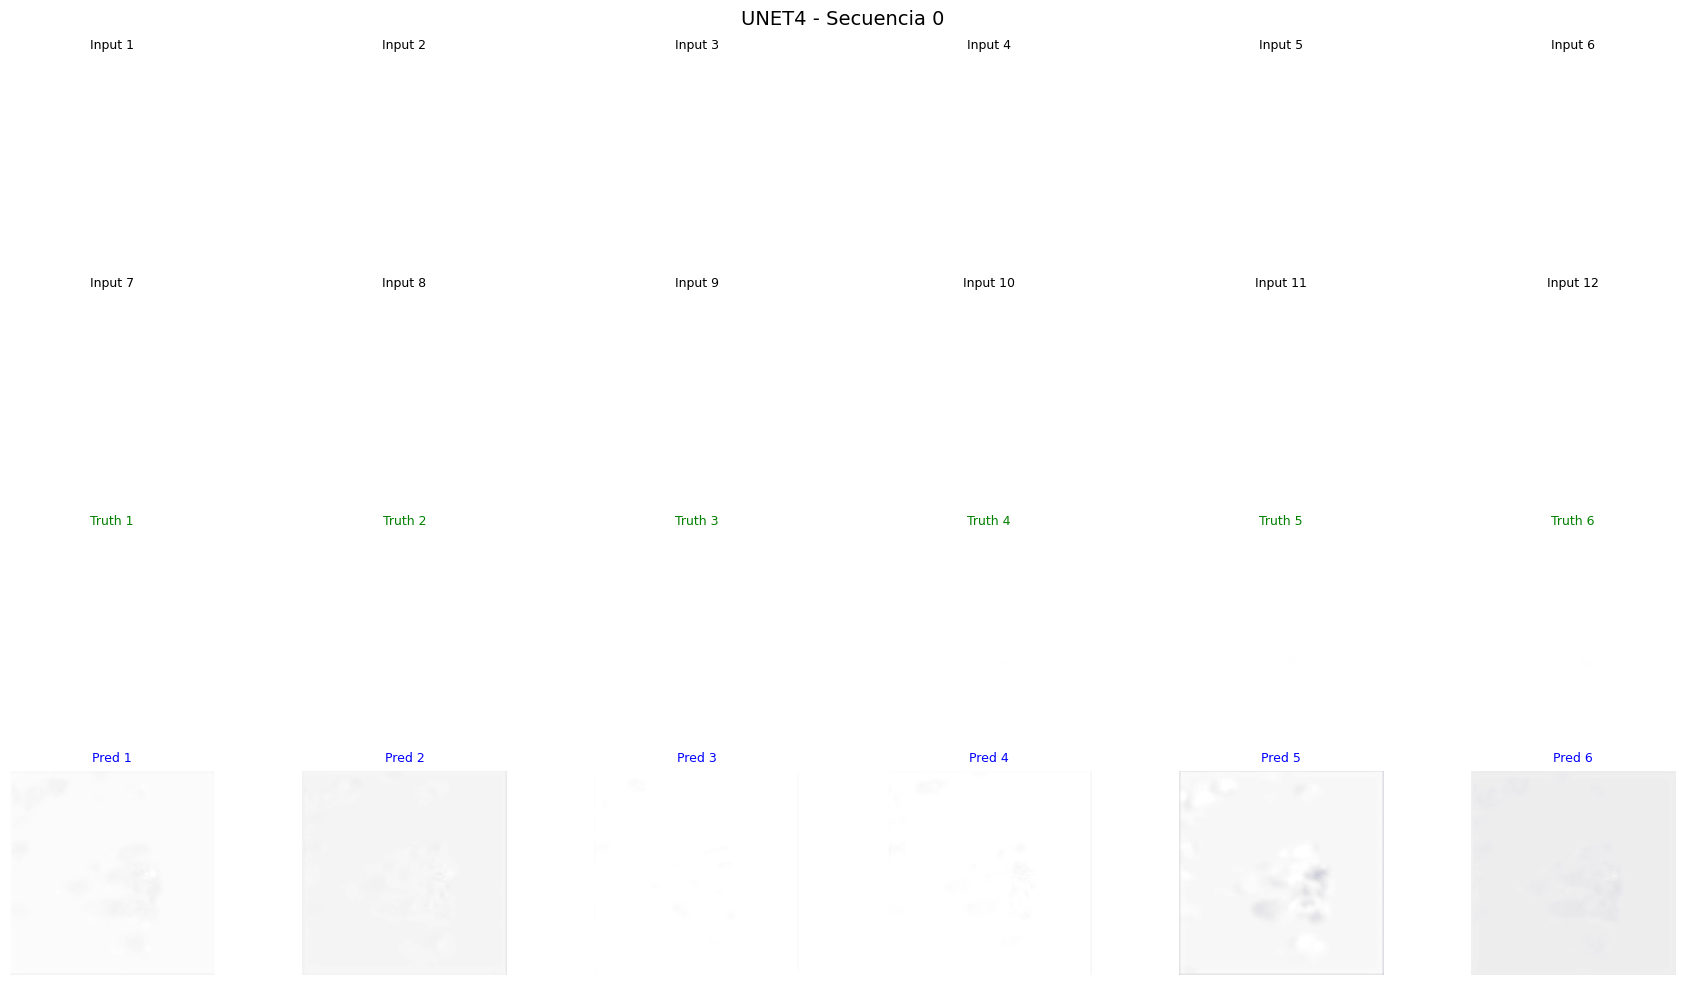

In [12]:
def show_prediction(model_name, seq_idx=0):
    """Muestra inputs, targets y predicciones para una secuencia"""
    data = results[model_name]
    
    # Datos
    inputs = data['inputs'][seq_idx]
    targets = data['targets'][seq_idx]
    preds = data['predictions'][seq_idx]
    
    # Crear figura
    fig = plt.figure(figsize=(18, 10))
    
    # Colormap personalizado
    colors = [(0, 0, 0, 0), (0, 0, 1, 0.7), (1, 0, 0, 0.7)]
    cmap = mcolors.LinearSegmentedColormap.from_list("rain", list(zip([0, 0.5, 1], colors)))
    
    # Inputs (2 filas de 6)
    for i in range(12):
        plt.subplot(4, 6, i+1)
        plt.imshow(inputs[i]*1, cmap=cmap, vmin=0, vmax=100)
        plt.title(f'Input {i+1}', fontsize=9)
        plt.axis('off')
    
    # Ground truth
    for i in range(6):
        plt.subplot(4, 6, 13+i)
        plt.imshow(targets[i]*1, cmap=cmap, vmin=0, vmax=100)
        plt.title(f'Truth {i+1}', fontsize=9, color='green')
        plt.axis('off')
    
    # Predicciones
    for i in range(6):
        plt.subplot(4, 6, 19+i)
        plt.imshow(preds[i], cmap=cmap, vmin=0, vmax=100)
        plt.title(f'Pred {i+1}', fontsize=9, color='blue')
        plt.axis('off')
    
    plt.suptitle(f'{model_name.upper()} - Secuencia {seq_idx}', fontsize=14)
    plt.tight_layout()
    plt.show()

# Visualizar una secuencia de cada modelo
for model in results.keys():
    show_prediction(model, seq_idx=0)

In [9]:
import h5py
with h5py.File(MODEL_PATHS['unet4'], 'r') as f:
    print("Estructura del archivo:")
    def print_structure(name, obj):
        print(f"  {name}: {type(obj)}")
        if hasattr(obj, 'shape'):
            print(f"    Shape: {obj.shape}")
            print(f"    Min: {obj[:].min():.6f}, Max: {obj[:].max():.6f}")
    
    f.visititems(print_structure)
    
    print("\nAtributos:")
    for key, value in f.attrs.items():
        print(f"  {key}: {value}")

Estructura del archivo:
  inputs: <class 'h5py._hl.dataset.Dataset'>
    Shape: (29, 12, 128, 128)
    Min: 0.000000, Max: 1.000000
  predictions: <class 'h5py._hl.dataset.Dataset'>
    Shape: (29, 6, 128, 128)
    Min: -12.729109, Max: 52.138268
  targets: <class 'h5py._hl.dataset.Dataset'>
    Shape: (29, 6, 128, 128)
    Min: 0.000000, Max: 1.000000

Atributos:
  input_frames: 12
  metric_csi: 0.19459979236125946
  metric_far: 0.7979018688201904
  metric_hss: 0.01891595870256424
  metric_mse: 0.008872074075043201
  model_type: unet4
  output_frames: 6
  timestamp: 2025/05/20 17:00
